# Análise Exploratória do Dataset

Este notebook apresenta a análise exploratória do conjunto de imagens de raio-X torácico utilizado para classificação de pneumonia.

O objetivo desta etapa é:

- Compreender a estrutura do dataset.
- Avaliar o balanceamento entre as classes.
- Investigar características visuais relevantes.
- Identificar possíveis artefatos.
- Justificar as escolhas metodológicas adotadas no projeto.

As decisões relacionadas à arquitetura do modelo, pré-processamento, data augmentation e uso de class weight são fundamentadas a partir desta análise. A

In [ ]:
import os
#A
NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, ".."))

print("Project root:", PROJECT_ROOT)

Project root: c:\projects\xray-project


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

## Estrutura do Dataset

Utilizamos o arquivo `train_metadata.csv`, previamente construído,
para analisar a distribuição das classes e as características básicas das imagens.

In [3]:
metadata_path = os.path.join(PROJECT_ROOT, "data", "metadata", "train_metadata.csv")
df = pd.read_csv(metadata_path)

print("Total de imagens:", len(df))
df.head()

Total de imagens: 5232


,filename,path,label,patient_id
0,NORMAL-1003233-0001.jpeg,c:\projects\xray-project\data\train\NORMAL\NOR...,0,1003233
1,NORMAL-1012843-0001.jpeg,c:\projects\xray-project\data\train\NORMAL\NOR...,0,1012843
2,NORMAL-1014768-0001.jpeg,c:\projects\xray-project\data\train\NORMAL\NOR...,0,1014768
3,NORMAL-1023731-0001.jpeg,c:\projects\xray-project\data\train\NORMAL\NOR...,0,1023731
4,NORMAL-1029510-0001.jpeg,c:\projects\xray-project\data\train\NORMAL\NOR...,0,1029510


## Distribuição das Classes

Analisamos a proporção entre imagens normais e imagens com pneumonia.

Essa etapa é fundamental para:

- Avaliar desbalanceamento.
- Justificar uso de class weight.
- Interpretar corretamente métricas como AUC.

label
1    3883
0    1349
Name: count, dtype: int64
label
1    0.742164
0    0.257836
Name: proportion, dtype: float64


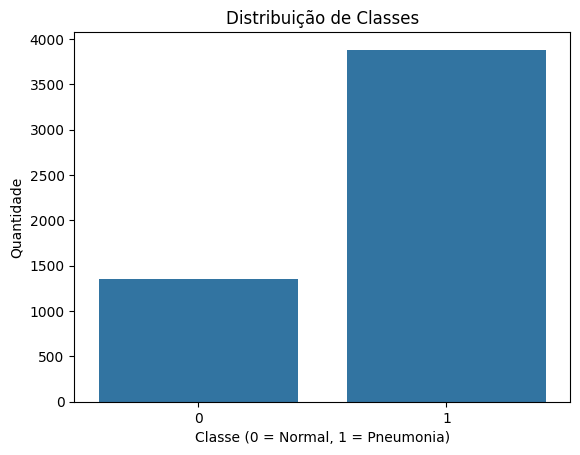

In [4]:
class_counts = df["label"].value_counts()
class_proportions = df["label"].value_counts(normalize=True)

print(class_counts)
print(class_proportions)

plt.figure()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Distribuição de Classes")
plt.xlabel("Classe (0 = Normal, 1 = Pneumonia)")
plt.ylabel("Quantidade")
plt.show()

Observa-se um desbalanceamento moderado, com maior proporção de imagens de pneumonia.

Esse cenário justifica a avaliação da hipótese relacionada ao uso de class weight,
uma vez que modelos treinados sem compensação podem favorecer a classe majoritária.

## Distribuição das Dimensões das Imagens

Verificamos a variabilidade nas dimensões originais das imagens.

Essa análise fundamenta a decisão de aplicar resize padronizado.

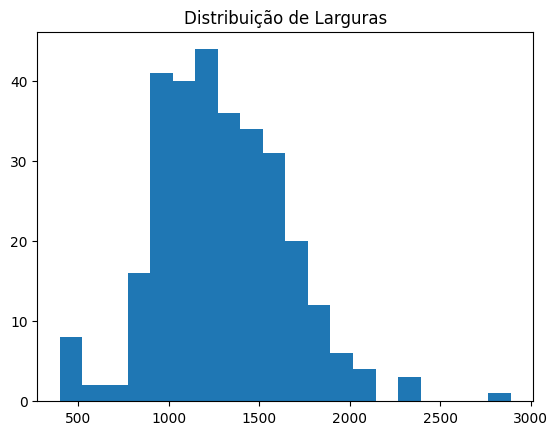

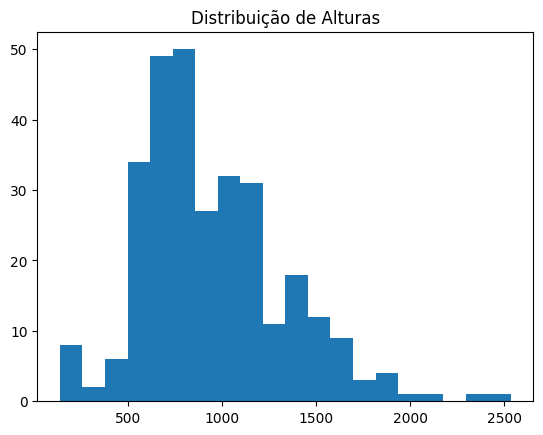

In [5]:
widths = []
heights = []

for path in df["path"].sample(300):  # amostra para acelerar
    img = Image.open(path)
    widths.append(img.size[0])
    heights.append(img.size[1])

plt.figure()
plt.hist(widths, bins=20)
plt.title("Distribuição de Larguras")
plt.show()

plt.figure()
plt.hist(heights, bins=20)
plt.title("Distribuição de Alturas")
plt.show()

As imagens apresentam variação nas dimensões originais.

Isso justifica o uso de resize para 224x224,
compatível com arquiteturas pré-treinadas como ResNet18 e DenseNet121.

## Exemplos Visuais das Classes

Visualizamos amostras aleatórias de cada classe para observar:

- Padrões anatômicos
- Regiões opacas
- Diferenças qualitativas entre classes

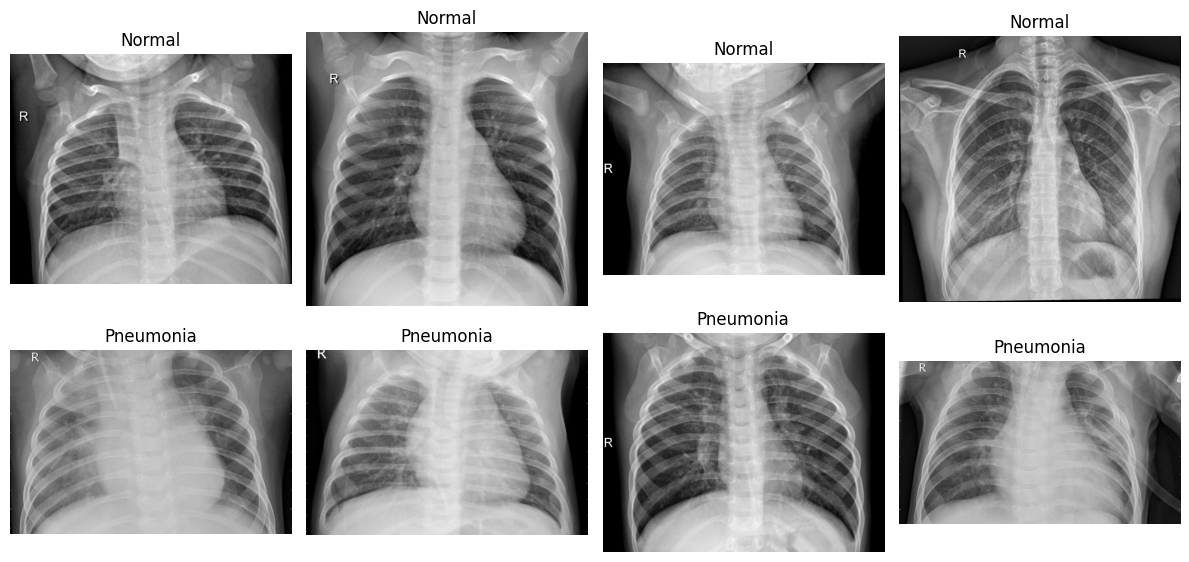

In [6]:
fig, axes = plt.subplots(2, 4, figsize=(12,6))

normal_samples = df[df["label"] == 0].sample(4)
pneumonia_samples = df[df["label"] == 1].sample(4)

for i, (_, row) in enumerate(normal_samples.iterrows()):
    img = Image.open(row["path"])
    axes[0, i].imshow(img, cmap="gray")
    axes[0, i].set_title("Normal")
    axes[0, i].axis("off")

for i, (_, row) in enumerate(pneumonia_samples.iterrows()):
    img = Image.open(row["path"])
    axes[1, i].imshow(img, cmap="gray")
    axes[1, i].set_title("Pneumonia")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

Observam-se diferenças visuais relacionadas a regiões de opacidade pulmonar.

Essas características são espaciais e texturais,
o que justifica a utilização de Redes Neurais Convolucionais (CNNs),
capazes de capturar padrões locais e hierárquicos.

## Distribuição de Intensidade de Pixels

Analisamos a distribuição global de intensidades
para fundamentar a normalização das imagens.

In [ ]:
pixel_values = []

for path in df["path"].sample(200):
    img = Image.open(path).convert("L")
    pixel_values.extend(np.array(img).flatten())

plt.figure()
plt.hist(pixel_values, bins=50)
plt.title("Distribuição de Intensidade de Pixels")
plt.show()

A ampla variação de intensidades reforça a necessidade de normalização,
especialmente ao utilizar modelos pré-treinados em ImageNet.

## Observação de Artefatos e Bordas

Algumas imagens apresentam:

- Bordas escuras
- Regiões externas irrelevantes
- Possíveis marcações hospitalares

Isso justifica a aplicação de CenterCrop,
reduzindo regiões periféricas potencialmente enviesadas.

## Discussão

A análise exploratória indica:

- Desbalanceamento moderado entre classes → Justifica teste com class weight.
- Variabilidade nas dimensões → Justifica resize padronizado.
- Presença de artefatos periféricos → Justifica CenterCrop.
- Padrões espaciais relevantes → Justifica uso de CNN.
- Diferenças visuais sutis → Justifica testar arquitetura mais profunda (DenseNet121).

Com base nessas observações, as hipóteses do projeto são fundamentadas empiricamente.